In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from vf_eni_dc.data import DataClass
from vf_eni_dc.cross_validation import PerformanceMeasuring

# loading the data and showing some statistics
We drop the last two rows as they are garbage. We can see that some of the variables are skewed, and `Tendency` has categorical values
The spearman rank plot shows a quite some uncorrelated regressors, with some clustering

Whole Dataset Outcomes: 
             prob  counts
outcome                  
1        0.778457    1655
2        0.138758     295
3        0.082785     176
out of 2126 samples


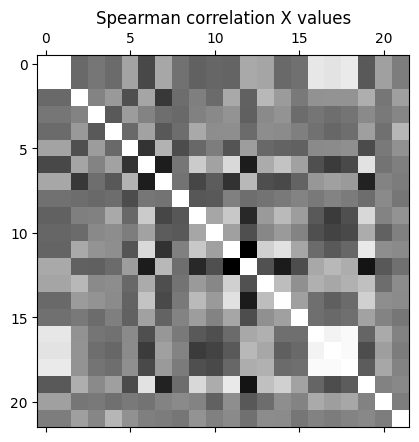

In [2]:
data_raw = DataClass.from_xlsx('./../data/cardiotocography/CTG.xls', encode=False, rescale=False,log_tran=None, drop_last=2)
data_raw.data_report()

We encode the 'Tendency' variable into dummies, we log-transform some of those, and we center and rescale all numeric features by their mean and variance.
Since we will consider the decision tree methods, we will permute the columns of the regressors to try to avoid the correlated regressor to be too close (grey lumps)

Whole Dataset Outcomes: 
             prob  counts
outcome                  
1        0.778457    1655
2        0.138758     295
3        0.082785     176
out of 2126 samples


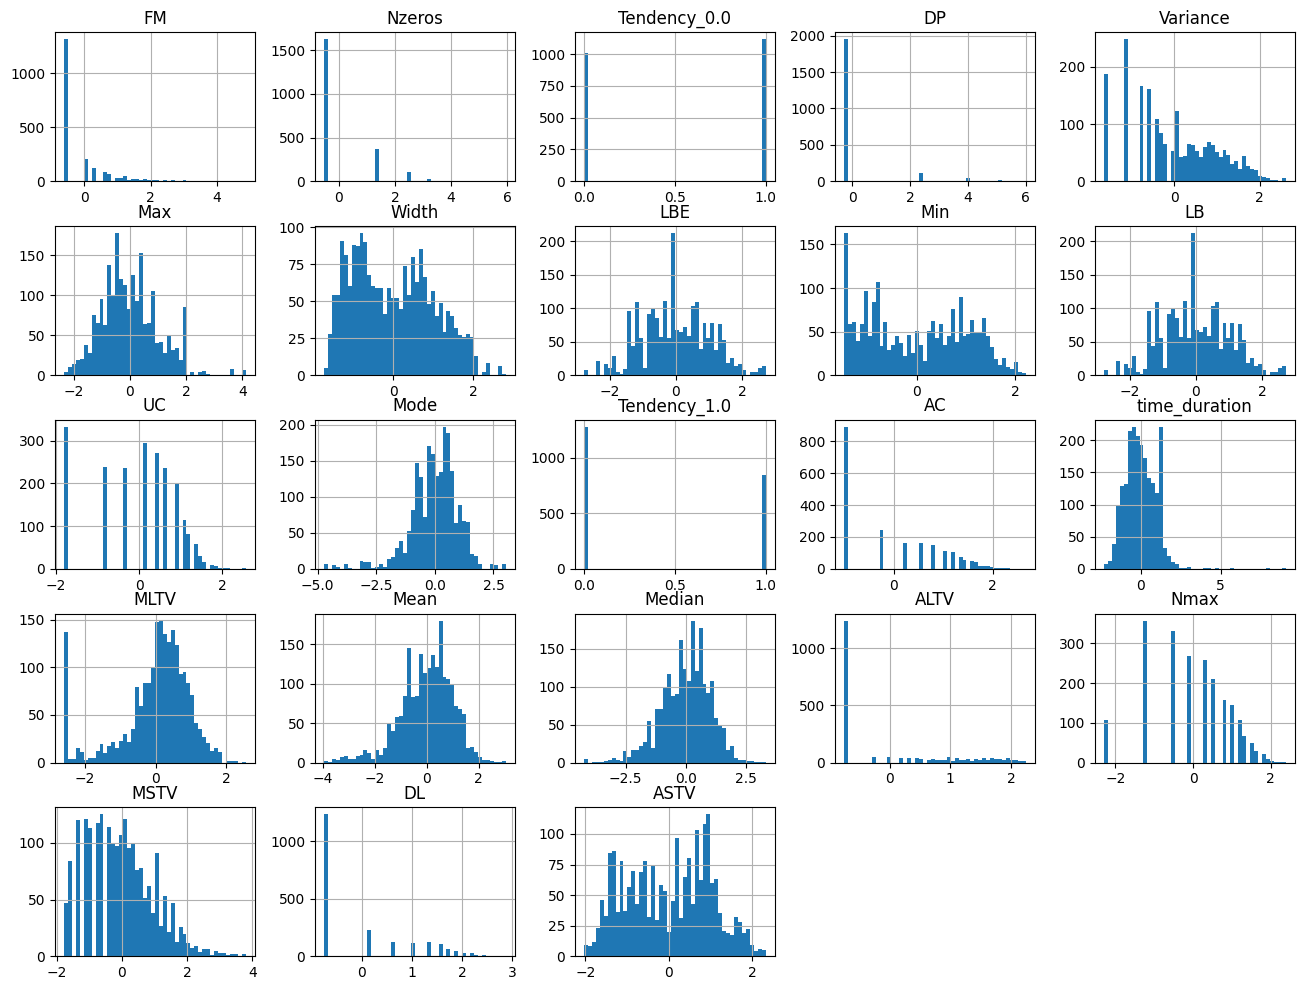

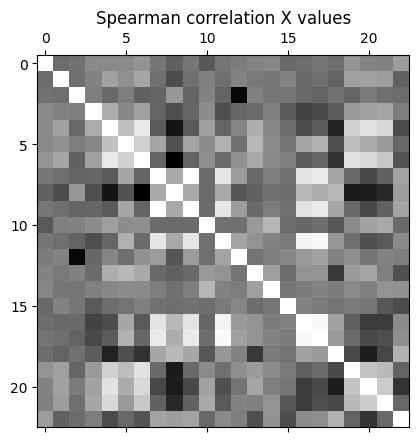

In [3]:
data = DataClass.from_xlsx('./../data/cardiotocography/CTG.xls', encode=True, rescale=True,
                           log_tran=['AC', 'FM', 'UC', 'MSTV', 'ALTV', 'DP', 'Nzeros', 'Nmax', 'Variance', 'DL', 'MLTV'],
                           permute_cols=True,
                           drop_last=2)
data.data_report()

We generate the train and the test split, where the test size are 20% of the total size, and we check that they are correctly stratified
NB: the random state is frozen, so the result are always the same

In [4]:
train, test = data.stratified_train_test_split(test_size=0.2, verbose=True)

Train Outcomes: 
             prob  counts
outcome                  
1        0.778235    1323
2        0.138824     236
3        0.082941     141
out of 1700 samples
Test Outcomes: 
             prob  counts
outcome                  
1        0.779343     332
2        0.138498      59
3        0.082160      35
out of 426 samples


###  We now want to try some run-of-the-mills models and compare them via cross validation
Since the class 3 is the scarcest, we need to ensure that we cover that in an adequate way.
We select `n_performance_fold=5`. Since we stratified the samples, every fold will have on average of 141*4/5=112.8 samples to train from and 28.2 samples to predict on class 3

In [5]:
cv_fold = 5
test_size = 0.2
performance = PerformanceMeasuring(data_class=data,n_performance_fold=cv_fold, test_size=test_size)

We create a small auxiliary function to fit quickly some models and store the confusion matrix

We try a simple logistic regression classifier, as baseline. Quite good on class 1

*** LogisticRegression ***
              precision    recall  f1-score   support

           1       0.95      0.96      0.96      1323
           2       0.69      0.73      0.71       236
           3       0.82      0.70      0.76       141

    accuracy                           0.90      1700
   macro avg       0.82      0.80      0.81      1700
weighted avg       0.90      0.90      0.90      1700



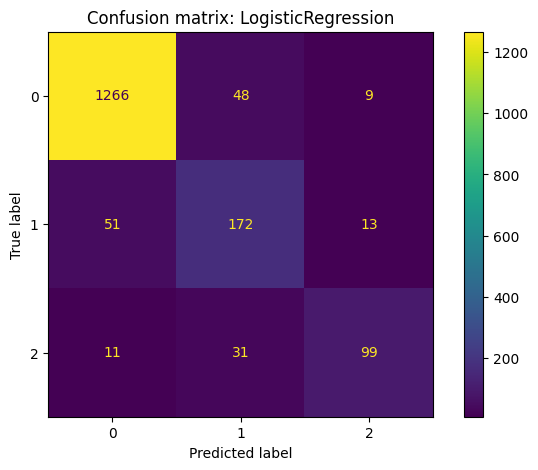

In [6]:
performance.fit_and_store(LogisticRegression(random_state=42, max_iter=10000))

We try a Gaussian Naive Bayes. Worse

*** GaussianNB ***
              precision    recall  f1-score   support

           1       0.97      0.83      0.90      1323
           2       0.49      0.84      0.62       236
           3       0.57      0.66      0.61       141

    accuracy                           0.82      1700
   macro avg       0.68      0.78      0.71      1700
weighted avg       0.87      0.82      0.84      1700



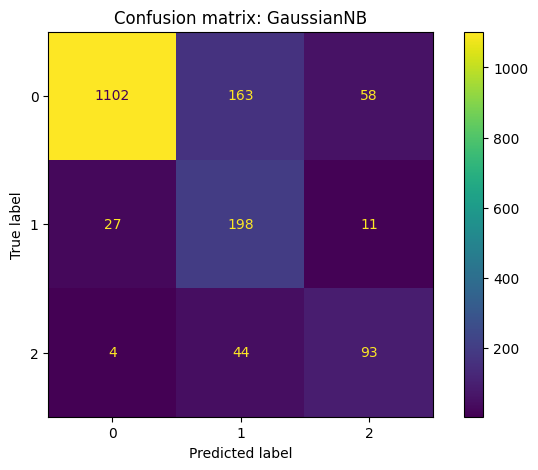

In [7]:
performance.fit_and_store(GaussianNB())

We now try the decision tree: improvements on all classes

*** DecisionTreeClassifier ***
              precision    recall  f1-score   support

           1       0.96      0.95      0.96      1323
           2       0.75      0.77      0.76       236
           3       0.90      0.91      0.91       141

    accuracy                           0.92      1700
   macro avg       0.87      0.88      0.87      1700
weighted avg       0.93      0.92      0.93      1700



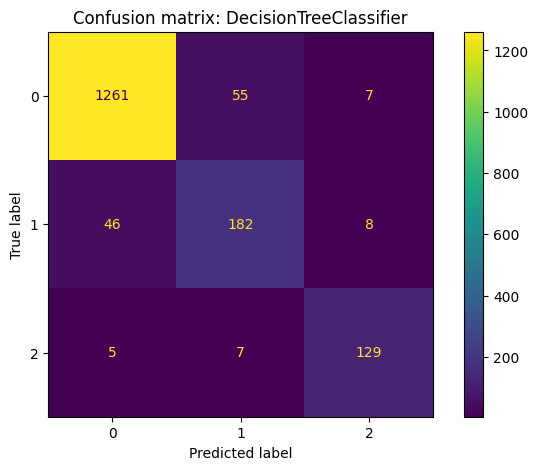

In [8]:
performance.fit_and_store(DecisionTreeClassifier(random_state=42))

Decision tree is the best method so-far, so we go for the classic random forest. Significant improvement on class 2

*** RandomForestClassifier ***
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      1323
           2       0.86      0.78      0.81       236
           3       0.94      0.87      0.90       141

    accuracy                           0.94      1700
   macro avg       0.92      0.87      0.89      1700
weighted avg       0.94      0.94      0.94      1700



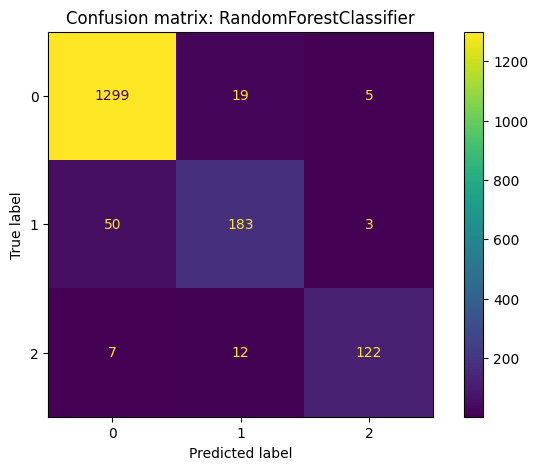

In [9]:
performance.fit_and_store(RandomForestClassifier(random_state=42))

As decision trees-based alternative, we try the GradientBoosting. Some small improvement on classes 2 and 3

In [10]:
performance.fit_and_store(GradientBoostingClassifier(random_state=24))

*** GradientBoostingClassifier ***
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      1323
           2       0.90      0.79      0.84       236
           3       0.96      0.92      0.94       141

    accuracy                           0.95      1700
   macro avg       0.94      0.90      0.92      1700
weighted avg       0.95      0.95      0.95      1700



We combine some of the above to see if we can improve the performance. It turns out, not at all

*** VotingClassifier ***
              precision    recall  f1-score   support

           1       0.97      0.95      0.96      1323
           2       0.71      0.85      0.78       236
           3       0.90      0.76      0.82       141

    accuracy                           0.92      1700
   macro avg       0.86      0.85      0.85      1700
weighted avg       0.93      0.92      0.92      1700



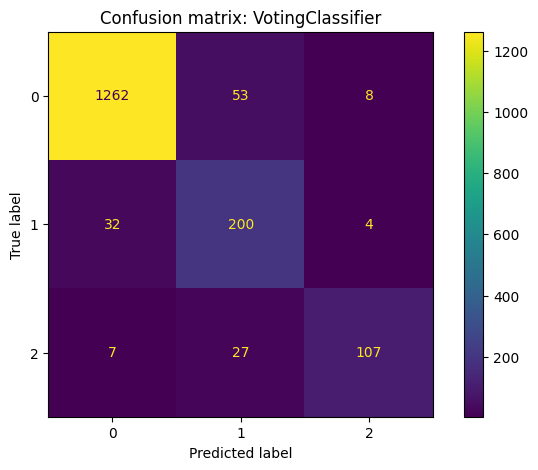

In [11]:
voters = (LogisticRegression(max_iter=10000), GaussianNB(), GradientBoostingClassifier(random_state=24))
voting = VotingClassifier([(type(v).__name__, v) for v in voters])
performance.fit_and_store(voting)

# We compare the models
We use as a metric the average f1 score, not to penalize any classes
The clear winner is the GradientBoosting method, with the voting classified second.
Since the added complexity of the voting classifier, it will not be considered for fine-tuning

In [12]:
performance.get_quick_fitting_results()

GradientBoostingClassifier    0.917907
RandomForestClassifier        0.894489
DecisionTreeClassifier        0.873571
VotingClassifier              0.853387
LogisticRegression            0.805734
GaussianNB                    0.709680
dtype: float64

# Fine tuning
We set up the parameters range to be explored via a random search

In [13]:
n_iter_random_search = 100

# base grid for the decision tree regressor
random_grid_common = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    }

We fine-tune a decision tree

In [14]:
random_grid_dt = {
    'criterion' : ['gini', 'entropy'],
}
random_grid_dt.update(random_grid_common)
dt = DecisionTreeClassifier(random_state=42)
random_search_result_dt = performance.run_random_search(
    estimator=dt,
    grid_parameter=random_grid_dt,
    n_cv_grid_search=cv_fold,
    n_samples_grid=n_iter_random_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
DecisionTreeClassifier(max_depth=110, max_features='sqrt', random_state=42)
0.8500658271060615
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'criterion': 'gini'}


In [15]:
performance.performance_on_test_set(random_search_result_dt)

              precision    recall  f1-score   support

           1       0.95      0.95      0.95       332
           2       0.71      0.71      0.71        59
           3       0.76      0.80      0.78        35

    accuracy                           0.90       426
   macro avg       0.81      0.82      0.81       426
weighted avg       0.90      0.90      0.90       426



DecisionTreeClassifier(max_depth=110, max_features='sqrt', random_state=42)

In [16]:
rf = RandomForestClassifier(random_state=42, n_estimators=1000)
random_grid_rf = {
    "bootstrap": [True, False],
    }
random_grid_rf.update(random_grid_dt)

random_search_result_rf = performance.run_random_search(
    estimator=rf,
    grid_parameter=random_grid_rf,
    n_cv_grid_search=cv_fold,
    n_samples_grid=n_iter_random_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       n_estimators=1000, random_state=42)
0.9081502104059428
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}


              precision    recall  f1-score   support

           1       0.95      0.98      0.96       332
           2       0.85      0.68      0.75        59
           3       0.88      0.83      0.85        35

    accuracy                           0.93       426
   macro avg       0.89      0.83      0.86       426
weighted avg       0.93      0.93      0.93       426



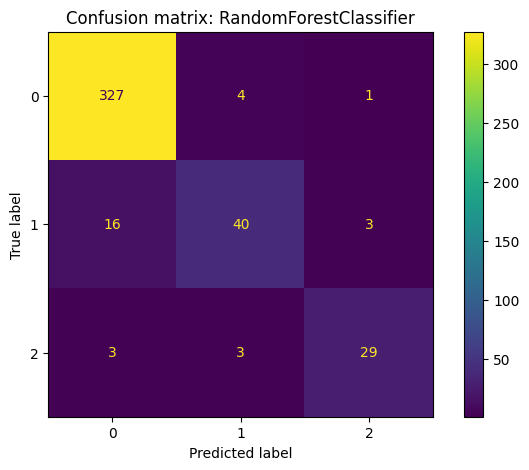

In [17]:
best_rf = performance.performance_on_test_set(random_search_result_rf)

In [18]:
from matplotlib import pyplot as plt

importance = np.vstack([e.feature_importances_ for e in best_rf.estimators_])
mean_importance = pd.Series(data=np.mean(importance, axis=0),
                            index=best_rf.feature_names_in_).sort_values(ascending=False)
std_importance = pd.Series(data=np.std(importance, axis=0), index=best_rf.feature_names_in_)
fig, ax = plt.subplots()
mean_importance.plot.bar(yerr=std_importance[mean_importance.index], ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [19]:
gbc = GradientBoostingClassifier(random_state=42, n_estimators=250)
bootstrap = [True, False]
gbc_parameters = {
    "learning_rate":[0.01, 0.1, 1, 10],
    'criterion' : ['friedman_mse', 'squared_error', 'absolute_error']
    }

gbc_parameters.update(random_grid_common)
random_search_result_gbc = performance.run_random_search(
    estimator=gbc,
    grid_parameter=gbc_parameters,
    n_cv_grid_search=cv_fold,
    n_samples_grid=n_iter_random_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
GradientBoostingClassifier(max_depth=20, max_features='auto',
                           min_samples_leaf=2, n_estimators=250,
                           random_state=42)
0.9190614638725176
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}


              precision    recall  f1-score   support

           1       0.96      0.98      0.97       332
           2       0.88      0.75      0.81        59
           3       0.89      0.91      0.90        35

    accuracy                           0.94       426
   macro avg       0.91      0.88      0.89       426
weighted avg       0.94      0.94      0.94       426



GradientBoostingClassifier(max_depth=20, max_features='auto',
                           min_samples_leaf=2, n_estimators=250,
                           random_state=42)

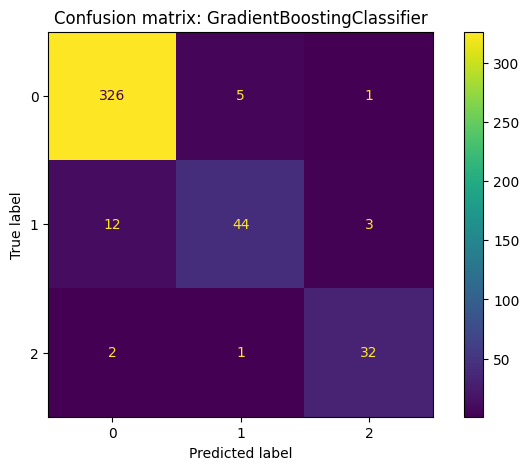

In [20]:
performance.performance_on_test_set(random_search_result_gbc)